In [1]:
import matplotlib.pyplot as plt

In [2]:
# Module for simulating infectious disease dynamics with the CMV model

import numpy as np, scipy.integrate, scipy.optimize, sys

In [3]:
class CMVsystem:

    def __init__(self, lam, mu, beta, alpha, delta,S0,p,c, S, L, I, V):
        self.lam = lam
        self.mu = mu
        self.beta = beta
        self.alpha = alpha
        self.delta=delta
        self.p = p
        self.c = c
        self.S0= S0
        self.t = 0.
        self.S = S
        self.L = L
        self.I = I
        self.V = V
        self.trajectory = np.array([[self.S, self.L, self.I,self.V]],dtype=float)
        self.times = None
#Define an initializer (__init__(self,beta,gamma,S,I,R)) which accepts model parameters beta and gamma, 
#and initial numbers of hosts in each of the S,I and R compartments.
    def reset(self, S, I, L, V,t=0.):
        self.t = t
        self.S = S
        self.L = L
        self.I = I
        self.V = V
        self.trajectory = np.array([[self.S, self.L, self.I, self.V]],dtype=float)

In [4]:
class DeterministicCMVsystem (CMVsystem):

    """Define a specialized subclass of the general SIRsystem for modeling SIR dynamics with a deterministic differential
    equation model"""

    def dydt(self, y, t):
        """Define the right-hand-side of the equation dy/dt = dydt(y,t) for use with odeint integrator;
        note that because this is defined as a method on the class rather than as a free-standing function, the first
        argument of the function must be the self instance rather than the current state vector y"""

        S,L,I,V = y
        dSdt = self.lam-self.mu*S-self.beta * S/self.S0 * V
        dLdt = self.beta * S/self.S0 * V - self.alpha *L
        dIdt = self.alpha *L-self.delta*I
        dVdt = self.p*I-self.c*V
        
        #here is the ode system, and in terms of concentration!
        return np.array([dSdt, dLdt, dIdt,dVdt])

    def run(self, T, dt=None):
        """Integrate the ODE for the deterministic model from time 0 to time T, starting with the initial values stored
        in the S,I,R state variables; story the result in self.trajectory"""

        y0 = np.array([self.S, self.L, self.I,self.V], dtype=float)
        if dt is None:
            self.times = np.linspace(0.,T, int(T+1), endpoint=True)
        else:
            self.times = np.arange(0.,T, dt)
        self.trajectory = scipy.integrate.odeint(self.dydt, y0, self.times)
        #self.trajectory = np.concatenate((self.trajectory, traj), axis=0)

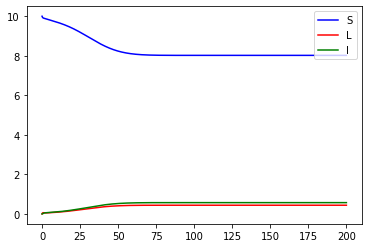

In [5]:
mu=1/4.5; beta=0.0012; alpha=1; delta=0.77; S0=10;lam=mu*S0 ;p=1600;c=2; S=S0; L=0; I=0; V=200;
dsird = DeterministicCMVsystem(lam, mu, beta, alpha, delta,S0,p,c, S, L, I, V)
dsird.run(200, 0.01) #run the system for T=30 with time increment=0.1
plt.plot(dsird.times, dsird.trajectory[:,0], 'b-', label='S')
plt.plot(dsird.times, dsird.trajectory[:,1], 'r-', label='L')
plt.plot(dsird.times, dsird.trajectory[:,2], 'g-', label='I')
#plt.plot(dsird.times, dsird.trajectory[:,3], 'y-', label='V')
plt.legend(loc='upper right')
#plt.yscale("log")

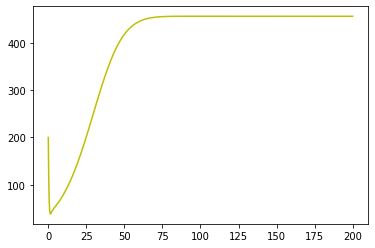

In [6]:
plt.plot(dsird.times, dsird.trajectory[:,3], 'y-', label='V')

for stochastic, we keep S constant

In [7]:
class StochasticCMVsystem (CMVsystem):

    """Define a specialized subclass of the general SIRsystem for modeling SIR dynamics as a stochastic, continuous
    time process, using the Gillespie method of continuous time Monte Carlo"""

    def step(self,ratio):
        """Implement one step of Gillespie's Direct Method based on current reaction rates: identify a reaction to fire
        next, as well as a time at which it will fire, and execute that reaction (similar to as was described in the
        StochasticCells exercise)."""
        s=np.random.uniform(0,1)
        transition = None
        S_birth=self.lam
        S_death=self.mu*self.S
        inf_rate=self.beta*self.V*self.S/self.S0
        
        L_to_I=self.alpha*self.I
        
        L_death=self.mu*self.L
        I_death=self.delta*self.I
        
        V_production=self.p*self.I
        
        V_death=self.c*self.V
        
        
        #S is kept constant
        #CASE1:with latent cells
        
        if s>ratio:
            rates=[inf_rate,L_to_I,L_death,I_death,V_production,V_death]
            total_rate=np.sum(rates)


            if total_rate == 0.:
                return transition, self.t
            if self.V==0:
                return transition, self.t
            if self.V==500:
                return transition, self.t
            ranno = np.random.random()
            if ranno < np.sum(rates[0:1])/total_rate:
                self.I += 1   #infected cell production
                transition = 1
            elif ranno < np.sum(rates[0:2])/total_rate:
                self.I+=1     #Latent cell become infected
                self.L-=1
                transition = 2
            elif ranno < np.sum(rates[0:3])/total_rate:
                self.L-=1      #Latent Cell death
                transition = 3
            elif ranno < np.sum(rates[0:4])/total_rate:
                self.I-=1      #Infected Cell death
                transition = 4
            elif ranno < np.sum(rates[0:5])/total_rate:
                self.V+=1
                transition = 5
            elif ranno < np.sum(rates[0:6])/total_rate:
                self.V-=1
                transition = 6
        
        
        #CASE2:no latent cells
        else:
            rates=[inf_rate,I_death,V_production,V_death]
            total_rate=np.sum(rates)



            if total_rate == 0.:
                return transition, self.t
            if self.V==0:
                return transition, self.t
            if self.V==500:
                return transition, self.t
            ranno = np.random.random()
            if ranno < np.sum(rates[0:1])/total_rate:
                self.I += 1
                transition = 1

            elif ranno < np.sum(rates[0:2])/total_rate:
                self.I-=1
                transition = 2
            elif ranno < np.sum(rates[0:3])/total_rate:
                self.V+=1
                transition = 3
            elif ranno < np.sum(rates[0:4])/total_rate:
                self.V-=1
                transition = 4
                
                
                
        dt = np.random.exponential(1./total_rate, 1)[0]
        #why 1/the hazard function? different from the textbook
        self.t += dt
        return transition, self.t


    def run(self, T=None, case=1, make_traj=True):
        """Run the Gillespie algorithm for stochastic simulation from time 0 to at least time T, starting with the initial
        values stored in the S,I,R state variables; story the result in self.trajectory if make_traj argument is
        set to True"""

        if T is None:
            T = sys.maxsize
        self.times = [0.]
        t0 = self.t
        transition = 1
        while self.t < t0 + T:
            transition, t = self.step(case)
            if not transition:
                return self.t
            if make_traj:
                self.trajectory = np.concatenate((self.trajectory, [[self.S,self.L,self.I,self.V]]), axis=0)
            self.times.append(self.t)
        return self.t

In [8]:
counter=0;
timer_infected=[];
timer_clear=[];


In [9]:
max_iter=2000;

In [10]:
s = np.random.poisson(331, max_iter)

In [11]:
for j in range(max_iter):
    infected=0;
    for i in range(s[j]):
        mu=1/4.5; beta=0.0012; alpha=1; delta=0.77; S0=400;lam=mu*S0 ;p=1600;c=2; S=S0; L=0; I=0; V=1;
        M1 =StochasticCMVsystem(lam, mu, beta, alpha, delta, S0,p,c, S, L, I, V);
        M1.run(3,0.5)
        if M1.trajectory[-1,3]>0:
            infected=1;
            timer_infected.append(M1.t)
        else:
            timer_clear.append(M1.t)
        if infected==1:
            break;
    if infected==1:
        counter+=1;

In [12]:
counter

328

In [18]:
counter/max_iter

0.2385

In [116]:
s = np.random.poisson(339.985, 100)

In [117]:
np.mean(timer_infected)

1.2297495182364817

In [118]:
np.mean(timer_clear)

0.499976801493222

Text(0.5, 1.0, 'Histogram of days to develop infection')

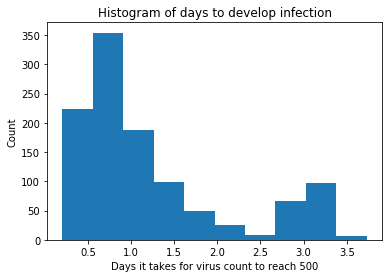

In [119]:
plt.hist(timer_infected)
plt.xlabel("Days it takes for virus count to reach 500")
plt.ylabel("Count")
plt.title("Histogram of days to develop infection")

Text(0.5, 1.0, 'Histogram of days to clear all virus')

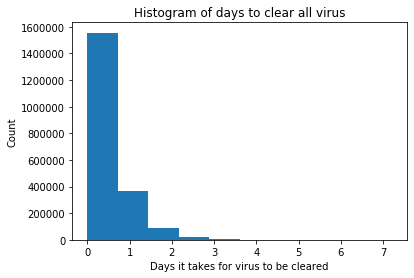

In [120]:
plt.hist(timer_clear)
plt.xlabel("Days it takes for virus to be cleared")
plt.ylabel("Count")
plt.title("Histogram of days to clear all virus")